In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt

In [2]:
class Node:
    def __init__(self,branches=None,attribute=None,threshold=None,value=None):
        if branches is None and value is None:
            print("ERROR")
        
        self.branches = branches
        self.threshold = threshold
        self.attribute = attribute
        self.is_leaf = True if self.branches is None else False
        self.value = value
        self.pinfo = {}
        
    def get_child(self,df):
        if isinstance(df[self.attribute],(int,float)):
            return self.branches[0] if df[self.attribute] < self.threshold else self.branches[1]
        else:
            return self.branches[0] if df[self.attribute] in self.threshold else self.branches[1]
        

In [3]:
class Tree:
    def __init__(self,root):
        self.root = root
        
    def predict(self,x):
        item = self.root
        while not item.is_leaf:
            item = item.get_child(x)
        return item
    
    def leaf_count(self):
        return self._leaf_count(self.root)
    
    def _leaf_count(self,node):
        if node.is_leaf:
            return 1
        else:
            return np.sum([self._leaf_count(b) for b in node.branches])
    
    def nodes(self):
        return self._nodes(self.root)
    
    def _nodes(self,node):
        if node.is_leaf:
            return [node]
        
        nl = [node]
        for b in node.branches:
            nl += self._nodes(b)
        return nl
        

In [4]:
l0= Node(value="young")
l1=Node(value="old")
r=Node([l0,l1],"age",18)
t=Tree(r)
print(t.predict({"age":2}).value)

young


In [5]:
print(t.predict({"age":20}).value)

old


In [6]:
t.leaf_count()

2

In [7]:
t.nodes()

In [8]:
class CART:
    def __init__(self,df,y_name,X_names):
        self.df = df
        self.y_name = y_name
        self.X_names = X_names
        self.tree = None
        self.splittyness = 1.
        self.leaf_loss_threshold = 1e-12
        
        self.classes = np.unique(df[self.y_name]).tolist()
        n = len(self.classes)
        self.confusion_matrix = np.zeros((n,n))
        
    def create_tree(self,splittyness=1., leaf_loss_threshold=1e-12):
        self.splittyness = splittyness
        self.leaf_loss_threshold = leaf_loss_threshold
        root = self._node_or_leaf(self.df)
        self.tree = Tree(root)
        return self.tree
    
    def _gini_impurity(self, df):
        unique, counts = np.unique(df[self.y_name].values, return_counts=True)
        N = df[self.y_name].values.ravel().size
        p = counts/N
        #print(unique)
        #print(p)
        return 1. - np.sum(p**2)
    
    def _shannon_entropy(self,df):
        unique, counts = np.unique(df[self.y_name].values, return_counts=True)
        N = df[self.y_name].values.size
        p = counts/N
        return -np.sum(p * np.log2(p))
    
    def _misclassification_cost(self,df):
        y = df[self.y_name].values
        unique, counts = np.unique(y, return_counts=True)
        N = y.size
        p = np.max(counts)/N
        return 1. - p
        
    def _opt_fun(self,df,split_name):
        def fun(x):
            split_df = [df[df[split_name]<x],
                        df[df[split_name]>=x]]
            N = len(df.index)
            n = [len(df_.index) for df_ in split_df]
            return n[0]/N * self._loss(split_df[0]) + n[1]/N * self._loss(split_df[1])
        return fun
        
    def _node_or_leaf(self,df):
        loss_parent = self._loss(df)
        if loss_parent < self.leaf_loss_threshold:
            return self._leaf(df)
        
        loss_best, split_df, split_threshold, split_name = self._loss_best(df)
        print(f"Computed split:\nloss: {loss_best:.2f} (parent: {loss_parent:.2f})\nattribute: {split_name}\nthreshold: {split_threshold}\ncount: {[len(df_.index) for df_ in split_df]}")
        if loss_best * self.splittyness < loss_parent:
            print(f"  => creating Node({split_name}, {split_threshold})\n")
            branches = []
            for i in range(2):
                branches.append(self._node_or_leaf(split_df[i]))
            unique, counts = np.unique(df[self.y_name], return_counts=True)
            value = unique[np.argmax(counts)]
            item = Node(branches=branches,attribute=split_name,threshold=split_threshold,value=value)
            item.pinfo["N"] = len(df.index)
            item.pinfo["r"] = self._misclassification_cost(df)
            item.pinfo["R"] = item.pinfo["N"]/len(self.df.index) * item.pinfo["r"]
        else:
            item = self._leaf(df)
            
        return item
    
    def _leaf(self,df):
        unique, counts = np.unique(df[self.y_name].values,return_counts=True)
        print([(unique[i], counts[i]) for i in range(len(counts))])
        sort_ind = np.argsort(-counts)
        value = unique[sort_ind[0]]
        leaf = Node(value=value)
        
        # confusion matrix
        i_predict = self.classes.index(value)
        for i, c in enumerate(unique):
            i_c = self.classes.index(c)
            self.confusion_matrix[i_c,i_predict] += counts[i]
        
        leaf.pinfo["N"] = len(df.index)
        leaf.pinfo["r"] = self._misclassification_cost(df)
        leaf.pinfo["R"] = leaf.pinfo["N"]/len(self.df.index) * leaf.pinfo["r"]
        print(f"  => creating Leaf({value}, N={len(df.index)})\n")
        return leaf
    
    def _loss_best(self,df):
        loss0 = 10
        for name in self.X_names:
            if np.issubdtype(df[name].values.dtype, np.number):
                #split_threshold_ = np.median(df[name].v
                res = opt.minimize_scalar(self._opt_fun(df,name),bounds=(df[name].min(),df[name].max()),method="bounded")
                split_threshold_ = res.x
                split_df_ = [df[df[name]<split_threshold_],
                        df[df[name]>=split_threshold_]]
                #loss = self._loss(split_df_[0]) + self._loss(split_df_[1])
                loss = res.fun
            else:
                unique = np.unique(df[name])
                split_threshold_ = [unique.ravel()[0]]
                split_df_ =[df[df[name].isin(split_threshold_)],
                            df[~df[name].isin(split_threshold_)]]
                N = len(df.index)
                n = [len(df_.index) for df_ in split_df_]
                loss = n[0]/N * self._loss(split_df_[0]) + n[1]/N * self._loss(split_df_[1])
            if loss < loss0:
                loss0 = loss
                split_threshold = split_threshold_
                split_df = split_df_
                split_name = name
                
        #print(loss0)
                
        return loss0, split_df, split_threshold, split_name
    
    def _loss(self,df):
        #return self._gini_impurity(df)
        return self._shannon_entropy(df)
    
    def metrics(self):
        P = self._precision(self.confusion_matrix)
        print(f"precision: {P}")
        R = self._recall(self.confusion_matrix)
        print(f"recall: {R}")
        F = np.mean(self._F1(P,R))
        print(f"F-score: {F}")
        return {"precision":P,
                "recall":R,
                "F-score":F}
    
    def _k_fold_miss(self,k=5,frac=0.5):
        R = []
        for i in range(k):
            df = self.df.sample(frac=frac, replace=True)
            r = self._miss(df)
            R.append(r)
        return R
    
    def prune(self):
        dict_list = []
        n_iter = 0
        g_min = 0
        print("n_leafs\tR\talpha")
        n_leafs, R = self._g2(self.tree.root)
        print(f"{n_leafs}\t{R:.4f}\t{g_min:.4f}")
        while self.tree.leaf_count() > 1 and n_iter < 100:
            n_iter += 1
            prune_dict = {}
            alpha = g_min
            prune_dict["alpha"] = alpha
            # compute g for all double leaf nodes
            nodes = self.tree.nodes()
            g = []
            pnodes = []
            for n in nodes:
                if not n.is_leaf:
                    g.append(self._g(n))
                    pnodes.append(n)
                    
            g_min = np.min(g)
            prune_dict["pruned_nodes"] = []
            for i, n in enumerate(pnodes):
                if g[i] <= g_min:
                    n.is_leaf = True
                    prune_dict["pruned_nodes"].append(n)
            N, R = self._g2(self.tree.root)
            print(f"{N}\t{R:.4f}\t{alpha:.4f}")
            
    
    def _g(self,node):
        n_leafs, R_desc = self._g2(node)
        R = node.pinfo["R"]
        #print(n_leafs, R, R_desc)
        return (R - R_desc)/(n_leafs - 1)
                              
    def _g2(self,node):
        n_leafs = 0
        R_desc = 0
        if node.is_leaf:
            return 1, node.pinfo["R"]
        
        for b in node.branches:
            nl, R = self._g2(b)
            n_leafs += nl
            R_desc += R
        return n_leafs, R_desc
           
            
            
                 
                              
        
    
    @staticmethod
    def _precision(m):
        return np.diag(m) / np.sum(m, axis=1)
        
    
    @staticmethod
    def _recall(m):
        return np.diag(m) / np.sum(m, axis=0)
    
    @staticmethod
    def _F1(P,R):
        #F = np.zeros_like(P)
        #for i in range(len(
        return 2 * P * R / (P + R)
            
        
        

In [9]:
df=pd.read_csv("iris.csv")

In [10]:
df.columns
X_names=["petal_length","petal_width"]
df[X_names]

,petal_length,petal_width
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


In [11]:
df.iloc[0]

sepal_length       5.1
sepal_width        3.5
petal_length       1.4
petal_width        0.2
species         setosa
Name: 0, dtype: object

In [12]:
c = CART(df,"species",X_names)
c.create_tree(splittyness=1.)


Computed split:
loss: 0.67 (parent: 1.58)
attribute: petal_length
threshold: 2.299870103801317
count: [50, 100]
  => creating Node(petal_length, 2.299870103801317)

[('setosa', 50)]
  => creating Leaf(setosa, N=50)

Computed split:
loss: 0.32 (parent: 1.00)
attribute: petal_width
threshold: 1.6456049530973362
count: [52, 48]
  => creating Node(petal_width, 1.6456049530973362)

Computed split:
loss: 0.15 (parent: 0.39)
attribute: petal_length
threshold: 4.722525262237567
count: [44, 8]
  => creating Node(petal_length, 4.722525262237567)

[('versicolor', 44)]
  => creating Leaf(versicolor, N=44)

Computed split:
loss: 0.69 (parent: 1.00)
attribute: petal_length
threshold: 5.418039949610882
count: [6, 2]
  => creating Node(petal_length, 5.418039949610882)

Computed split:
loss: 0.46 (parent: 0.92)
attribute: petal_length
threshold: 4.914595931827383
count: [3, 3]
  => creating Node(petal_length, 4.914595931827383)

[('versicolor', 3)]
  => creating Leaf(versicolor, N=3)

Computed split:
l

In [13]:
c.tree.predict(df.iloc[0]).value

'setosa'

In [14]:
c.tree.root.branches[0].pinfo


{'N': 50, 'r': 0.0, 'R': 0.0}

In [15]:
c.prune()


n_leafs	R	alpha
12	0.0067	0.0000
11	0.0067	0.0000
7	0.0133	-0.0000
3	0.0400	0.0017
2	0.3333	0.0067
1	0.6667	0.2933


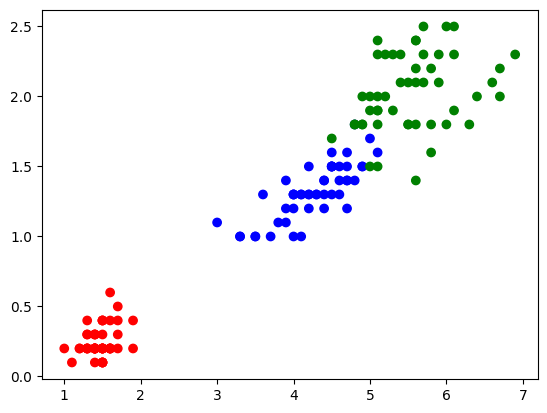

In [16]:
import matplotlib.pyplot as plt
colors = {"setosa":"red", "versicolor":"blue", "virginica":"green"}
plt.scatter(df["petal_length"],df["petal_width"],c=df["species"].map(colors))


In [17]:

x, y = np.meshgrid(np.linspace(1,7,11),np.linspace(0,2.5,11))
col = []
for i in range(len(x.ravel())):
    d = df.iloc[120].copy()
    d["petal_length"] = x.ravel()[i]
    d["petal_width"] = y.ravel()[i]
    col.append(c.tree.predict(d).value)
for i in range(len(col)):
    if col[i] == "setosa":
        col[i] = 0
    if col[i] == "versicolor":
        col[i] = 1
    if col[i] == "virginica":
        col[i] = 2
z = np.array(col).reshape(x.shape)

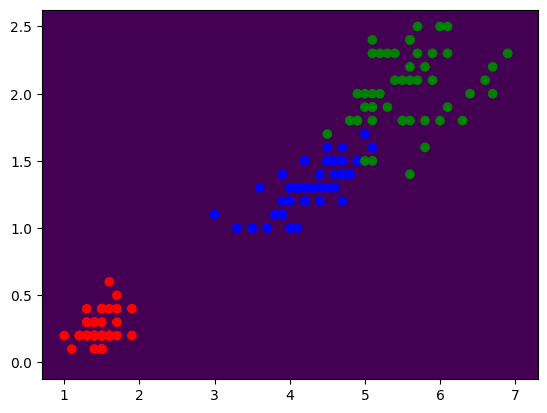

In [18]:
fig, ax = plt.subplots()
ax.pcolormesh(x,y,z)
ax.scatter(df["petal_length"],df["petal_width"],c=df["species"].map(colors))

In [19]:
c.confusion_matrix
c.metrics()

precision: [1.   0.98 1.  ]
recall: [1.         1.         0.98039216]
F-score: 0.9933326665999934


{'precision': array([1.  , 0.98, 1.  ]),
 'recall': array([1.        , 1.        , 0.98039216]),
 'F-score': 0.9933326665999934}

In [20]:
titanic = pd.read_csv("titanic.csv")
titanic

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


In [21]:
titanic.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare'],
      dtype='object')

In [22]:

c_titanic = CART(titanic,"Survived",["Pclass","Age","Fare","Siblings/Spouses Aboard","Sex","Parents/Children Aboard"])
c_titanic.create_tree(splittyness=1.01)

Computed split:
loss: 0.75 (parent: 0.96)
attribute: Sex
threshold: ['female']
count: [314, 573]
  => creating Node(Sex, ['female'])

Computed split:
loss: 0.62 (parent: 0.82)
attribute: Pclass
threshold: 2.236073938360776
count: [170, 144]
  => creating Node(Pclass, 2.236073938360776)

Computed split:
loss: 0.29 (parent: 0.30)
attribute: Pclass
threshold: 1.9999940391390134
count: [94, 76]
  => creating Node(Pclass, 1.9999940391390134)

Computed split:
loss: 0.15 (parent: 0.20)
attribute: Age
threshold: 9.225350274512522
count: [1, 93]
  => creating Node(Age, 9.225350274512522)

[(0, 1)]
  => creating Leaf(0, N=1)

Computed split:
loss: 0.14 (parent: 0.15)
attribute: Parents/Children Aboard
threshold: 1.2360739383607762
count: [81, 12]
  => creating Node(Parents/Children Aboard, 1.2360739383607762)

Computed split:
loss: 0.05 (parent: 0.10)
attribute: Fare
threshold: 32.32809963490821
count: [7, 74]
  => creating Node(Fare, 32.32809963490821)

Computed split:
loss: 0.29 (parent: 0.59)

In [23]:

c_titanic.metrics()

precision: [0.92110092 0.95614035]
recall: [0.97098646 0.88378378]
F-score: 0.9319626949364141


{'precision': array([0.92110092, 0.95614035]),
 'recall': array([0.97098646, 0.88378378]),
 'F-score': 0.9319626949364141}

In [29]:
c_titanic.prune()


n_leafs	R	alpha
205	0.0654	0.0000
204	0.0654	0.0000
192	0.0654	-0.0000
190	0.0654	-0.0000
187	0.0654	-0.0000
182	0.0654	-0.0000
181	0.0654	0.0000
178	0.0654	0.0000
164	0.0676	0.0000
158	0.0688	0.0002
149	0.0710	0.0002
145	0.0722	0.0003
139	0.0744	0.0003
130	0.0778	0.0004
127	0.0789	0.0004
124	0.0800	0.0004
110	0.0857	0.0004
102	0.0891	0.0004
97	0.0913	0.0004
82	0.0981	0.0005
77	0.1003	0.0005
60	0.1082	0.0005
56	0.1105	0.0005
50	0.1139	0.0006
48	0.1150	0.0006
46	0.1161	0.0006
44	0.1172	0.0006
41	0.1195	0.0006
38	0.1218	0.0008
37	0.1229	0.0008
35	0.1251	0.0011
28	0.1330	0.0011
27	0.1342	0.0011
26	0.1353	0.0011
25	0.1364	0.0011
23	0.1398	0.0011
21	0.1432	0.0017
9	0.1657	0.0017
5	0.1849	0.0019
4	0.1928	0.0048
2	0.2142	0.0079
1	0.3856	0.0107


In [24]:

penguins = pd.read_csv("penguins.txt").dropna()
penguins.columns

Index(['rowid', 'species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')

In [25]:
penguins

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...,...
339,340,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,341,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,342,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,343,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [26]:
c_penguins = CART(penguins,"species",["island","bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g","sex"])

In [27]:
c_penguins.create_tree()

Computed split:
loss: 0.75 (parent: 1.52)
attribute: flipper_length_mm
threshold: 204.2148442023583
count: [204, 129]
  => creating Node(flipper_length_mm, 204.2148442023583)

Computed split:
loss: 0.32 (parent: 0.92)
attribute: bill_length_mm
threshold: 43.7024625460616
count: [145, 59]
  => creating Node(bill_length_mm, 43.7024625460616)

Computed split:
loss: 0.16 (parent: 0.25)
attribute: bill_length_mm
threshold: 40.80883044958529
count: [110, 35]
  => creating Node(bill_length_mm, 40.80883044958529)

[('Adelie', 110)]
  => creating Leaf(Adelie, N=110)

Computed split:
loss: 0.24 (parent: 0.66)
attribute: sex
threshold: ['female']
count: [9, 26]
  => creating Node(sex, ['female'])

Computed split:
loss: 0.46 (parent: 0.92)
attribute: island
threshold: ['Dream']
count: [7, 2]
  => creating Node(island, ['Dream'])

Computed split:
loss: -0.00 (parent: 0.59)
attribute: bill_depth_mm
threshold: 18.222799294885117
count: [6, 1]
  => creating Node(bill_depth_mm, 18.222799294885117)

[('

In [28]:
c_penguins.metrics()

precision: [1. 1. 1.]
recall: [1. 1. 1.]
F-score: 1.0


{'precision': array([1., 1., 1.]),
 'recall': array([1., 1., 1.]),
 'F-score': 1.0}